In [1]:
import nest_asyncio
import base64
import logging
import os

from bs4 import BeautifulSoup
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from crawl4ai import AsyncWebCrawler
from dotenv import load_dotenv
from fastembed import TextEmbedding
from IPython.display import HTML
from langchain_anthropic import ChatAnthropic
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from langgraph.graph import START, END, StateGraph
from langchain.prompts import PromptTemplate
from langchain_core.tools import StructuredTool

from llama_index.core import PropertyGraphIndex 
from llama_index.core.indices.property_graph import VectorContextRetriever, LLMSynonymRetriever
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.llms.openai import OpenAI
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore

from pymilvus import (
    model, connections, Collection, AnnSearchRequest, RRFRanker,
)

from serpapi import GoogleSearch

from typing import Dict, List, Sequence, TypedDict, DefaultDict, Any, Optional
from typing_extensions import TypedDict, Annotated

In [2]:
nest_asyncio.apply()

logger = logging.getLogger(__name__)

if not logger.hasHandlers():
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

### Loading of LLMs and Embedding Models
1. Llama Models
2. Normal Models
3. Embedding Models

In [3]:
load_dotenv()

CLAUDE_API_KEY = os.getenv('CLAUDE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

os.environ["ANTHROPIC_API_KEY"] = CLAUDE_API_KEY

In [4]:
openai_llama = OpenAI(model="gpt-3.5-turbo-0125", openai_api_key=OPENAI_API_KEY, temperature=0.0)
claude_llama = Anthropic(model="claude-3-5-sonnet-20240620", api_key=CLAUDE_API_KEY, temperature=0.0)

In [5]:
claude = ChatAnthropic(
    model="claude-3-5-sonnet-20240620",
    temperature=0.0,
    stop=["\n\nHuman"],
    streaming=True,
    stream_usage=True
)

In [6]:
bge_embed_model = TextEmbedding(model_name="BAAI/bge-large-en-v1.5")
openai_embed_model = OpenAIEmbedding(model_name="text-embedding-3-small")
splade_embed_model = model.sparse.SpladeEmbeddingFunction(
    model_name="naver/splade-cocondenser-ensembledistil",
    device="cpu",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

## Connect to Zillis

In [7]:
ENDPOINT = os.getenv('ZILLIS_ENDPOINT')
TOKEN = os.getenv('ZILLIS_TOKEN')

connections.connect(uri=ENDPOINT, token=TOKEN)

In [8]:
collection_name = "vector_index"
collection = Collection(name=collection_name)

## Connect to Graph Store

In [9]:
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "15082001"
NEO4J_DATABASE = "neo4j"

graph_store = Neo4jPropertyGraphStore(
    username=NEO4J_USER,
    password=NEO4J_PASSWORD,
    url=NEO4J_URI,
    refresh_schema=False,
)

In [10]:
index = PropertyGraphIndex.from_existing(
    llm = claude_llama,
    embed_model=openai_embed_model,
    property_graph_store=graph_store,
)

vector_retriever = VectorContextRetriever(
  index.property_graph_store,
  vector_store=index.vector_store,
  embed_model=openai_embed_model,
)

keyword_retriever = LLMSynonymRetriever(
    index.property_graph_store, 
    llm=claude_llama,
    path_depth=1,
)

kg_retriever = index.as_retriever(sub_retrievers=[vector_retriever, keyword_retriever])

### Define GraphState's Storage Parameters

In [11]:
def reduce_defaultdicts(d1, d2):
    # Create a new defaultdict of lists
    merged = defaultdict(str)
    for key, value in d1.items():
        merged[key] = value
    for key, value in d2.items():
        merged[key] = value
    return merged

In [12]:
class GraphState(TypedDict):
    """
    Represents the state of a graph.

    Attributes:
        query (str): The user query
        query_list (List[str]): The expanded list of queries based on the user query
        agent (str): The agent responsible for decision making/answer generating
        --- DEPRECATED --- contexts (DefaultDict[str, str]): The contexts retrieved. Keys are "kg" or "db" indicating the source of the context, and values are the contexts themselves.
        kg_context (str): The context retrieved from the knowledge graph
        db_context (str): The context retrieved from the vector database
        websearch_context (str): The context retrieved from the web search
        metrics (DefaultDict[str, str]): The numerical evaluations of metrics, such as "correctness", "relevance", "clarity", etc.
        reasons (DefaultDict[str, str]): The reasons for the the metrics. Keys are the metric names, and values are the reasons.
        answer (str): The answer generated by the agent
    """
    query: str
    query_list: List[str]
    agent: str
    # contexts: Annotated[DefaultDict[str, str], reduce_defaultdicts]
    kg_context: str
    db_context: str
    websearch_context: str
    metrics: DefaultDict[str, str]
    reasons: DefaultDict[str, str]
    answer: str

### Define Helper Functions
1. search_kg_db (retrieves context from KG according to query)
2. search_vector_db (retrieves context from a traditional vector DB according to query)
3. get_kg_context (uses parallel processing to retrieve all contexts required from a query list, and formats it -- kg)
4. get_db_context (uses parallel processing to retrieve all contexts required from a query list, and formats it -- vector DB)

In [13]:
def search_kg_db(query: str, retriever) -> str:
    """
    Helper Function to retrieve context from KG a single query

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    return f"{retriever.get_context(query)}"

def search_vector_db(query: str, retriever) -> str:
    """
    Helper Function to retrieve context from KG a single query

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    return f"{retriever.get_context(query)}"

In [14]:
def get_kg_context(queries: List[str], retriever) -> str:
    """
    Uses parallel processing to retrieve context from the KG for a list of queries.

    Args:
        query_list (List[str]): The list of user queries

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """

    context = []
        
    with ThreadPoolExecutor() as executor:
        future_to_query = {executor.submit(search_kg_db, query, retriever): query for query in queries}
        for future in as_completed(future_to_query):
            query = future_to_query[future]
            try:
                result = future.result()
                context.append(result)
            except Exception as exc:
                print(f"Query {query} generated an exception: {exc}")

    return "\n\n".join(context)

def get_db_context(queries: List[str], retriever) -> str:
    """
    Uses parallel processing to retrieve context from a Vector DB for a list of queries.

    Args:
        queries (List[str]): The list of user queries

    Returns:
        str: The formatted context retrieved from the DB
    """
    
    context = []
        
    with ThreadPoolExecutor() as executor:
        future_to_query = {executor.submit(search_vector_db, query, retriever): query for query in queries}
        for future in as_completed(future_to_query):
            query = future_to_query[future]
            try:
                result = future.result()
                context.append(result)
            except Exception as exc:
                print(f"Query {query} generated an exception: {exc}")

    return "\n\n".join(context)

### Define Agents
1. Retrieval Agent (retrieves from kg_db and vector_db)
2. Answer Generation Agent (uses context from vector_db to generate answer)
3. Grading Agent (grades previously generated answer)
4. Display Subgraph Agent (multi hops for context expansion)
5. Refine Answer Agent (uses context retrieved from kg_db to refine previous answer)
6. Regrading Agent (regrades the final answer)

In [15]:
def query_expansion(query: str) -> List[str]:
    """
    Expands a query using LLM

    Args:
        query (str): The user query

    Returns:
        List[str]: The expanded queries
    """
    
    prompt = """<system>
    You are a creative AI assistant specializing in expanding user queries to make them more comprehensive and diverse. Your goal is to generate multiple variant queries based on the initial user query, capturing different aspects, synonyms, related terms, and broader or narrower contexts. Ensure that the expanded queries are relevant, diverse, and avoid repetition.
    </system>

    <instructions>
    1. Take the initial query provided by the user.
    2. Generate 2 variant queries that explore different interpretations, related topics, or alternative phrasings.
    3. Ensure the variants cover a range of specific to broad scopes and use synonyms or related terms.
    4. Avoid repeating the same information or using overly similar phrasing.
    5. Output the expanded queries in a JSON format, following the examples provided.
    6. Do not include any preamble, explanation, or additional information beyond the expanded queries in the given JSON format.
    </instructions>

    <example_output>
    Query: "machine learning algorithms"
    {{
        "query_list": [
            "types of machine learning algorithms",
            "applications of supervised learning techniques",
        ]
    }}
    <example_output>

    <query>
    {query}
    </query>
    
    <response>
    [Your JSON only response here]
    </response>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query"],
        template=prompt
    )
    
    chain = prompt_template | claude | JsonOutputParser()
    query_list = chain.invoke({"query": query})
    return query_list["query_list"]

In [16]:
query_expansion_tool = StructuredTool.from_function(
    func=query_expansion,
    name="Query Expansion",
    description="Expands a query using LLM"
)

In [17]:
def query_expansion_agent(state: GraphState) -> GraphState:
    """
    Agent that expands the user query

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    query_list = query_expansion_tool.invoke(state["query"])
    return {"query_list": query_list}

In [18]:
def retrieve_db(query: str) -> str:
    """
    Retrieves context from a conventional Vector DB, given a list of queries.

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from Vector DB
    """
    
    dense_embedding = list(bge_embed_model.query_embed(query))[0]
    sparse_embedding = list(splade_embed_model.encode_queries([query]))
    
    search_results = collection.hybrid_search(
            reqs=[
                AnnSearchRequest(
                    data=[dense_embedding],  # content vector embedding
                    anns_field='dense_embeddings',  # content vector field
                    param={"metric_type": "COSINE", "params": {"M": 64, "efConstruction": 512}}, # Search parameters
                    limit=3
                ),
                AnnSearchRequest(
                    data=list(sparse_embedding),  # keyword vector embedding
                    anns_field='sparse_embeddings',  # keyword vector field
                    param={"metric_type": "IP", "params": {"drop_ratio_build": 0.2}}, # Search parameters
                    limit=3
                )
            ],
            output_fields=['doc_id', 'text', 'doc_source'],
            rerank=RRFRanker(),
            limit=3
            )
    
    hits = search_results[0]
    
    context = []
    for res in hits:
        text = res.text
        source = res.doc_source
        context.append(f"Source: {source}\nContext: {text}")
    
    return "\n\n".join(context)

async def retrieve_db_async(query: str) -> str:
    """
    Retrieves context from a conventional Vector DB, given a list of queries.

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from Vector DB
    """
    
    dense_embedding = list(bge_embed_model.query_embed(query))[0]
    sparse_embedding = list(splade_embed_model.encode_queries([query]))
    
    search_results = collection.hybrid_search(
            reqs=[
                AnnSearchRequest(
                    data=[dense_embedding],  # content vector embedding
                    anns_field='dense_embeddings',  # content vector field
                    param={"metric_type": "COSINE", "params": {"M": 64, "efConstruction": 512}}, # Search parameters
                    limit=3
                ),
                AnnSearchRequest(
                    data=list(sparse_embedding),  # keyword vector embedding
                    anns_field='sparse_embeddings',  # keyword vector field
                    param={"metric_type": "IP", "params": {"drop_ratio_build": 0.2}}, # Search parameters
                    limit=3
                )
            ],
            output_fields=['doc_id', 'text', 'doc_source'],
            rerank=RRFRanker(),
            limit=3
            )
    
    hits = search_results[0]
    
    context = []
    for res in hits:
        text = res.text
        source = res.doc_source
        context.append(f"Source: {source}\nContext: {text}")
    
    return "\n\n".join(context)

In [19]:
retrieve_db_tool = StructuredTool.from_function(
    func=retrieve_db,
    coroutine=retrieve_db_async,
    name="Retrieve Vector DB",
    description="Retrieves context from a conventional Vector DB, given a list of queries."
)

In [20]:
async def retrieve_db_agent(state: GraphState) -> GraphState:
    """
    Agent that retrieves context from a Vector DB

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    logger.info("------- Retrieving Context Via Vector DB -------")
    context = retrieve_db_tool.invoke({"query": state["query"]})
    return {"db_context": context}

In [21]:
def retrieve_kg(query: str) -> str:
    """
    Retrieves context from the ingested knowledge graph, given a list of queries.
    Processes queries in parallel using ThreadPoolExecutor.

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    
    nodes = kg_retriever.retrieve(query)
    context = '\n\n'.join([node.text for node in nodes])
    return context

async def retrieve_kg_async(query: str) -> str:
    """
    Retrieves context from the ingested knowledge graph, given a list of queries.
    Processes queries in parallel using ThreadPoolExecutor.

    Args:
        query (str): The user query

    Returns:
        str: The formatted context retrieved from the knowledge graph
    """
    
    nodes = kg_retriever.retrieve(query)
    context = '\n\n'.join([node.text for node in nodes])
    return context

In [22]:
retrieve_kg_tool = StructuredTool.from_function(
    func=retrieve_kg,
    coroutine=retrieve_kg_async,
    name="Retrieve Knowledge Graph",
    description="Retrieves context from the ingested knowledge graph, given a list of queries"
)

In [23]:
async def retrieve_kg_agent(state: GraphState) -> GraphState:
    """
    Agent that retrieves context from the ingested knowledge graph

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    logger.info("------- Retrieving Context Via KG DB -------")
    context = retrieve_kg_tool.invoke({"query": state["query"]})
    return {"kg_context": context}

In [24]:
async def websearch(query: str, num_results: int = 3) -> str:
    """
    Retrieves context from the web using SerpAPI for search and AsyncWebCrawler for content

    Args:
        query (str): The user query
        num_results (int): Number of top results to crawl (default: 3)
        
    Returns:
        str: The formatted context retrieved from the websearch
    """
    logger.info("------- Retrieving Context Via Web Search -------")
    # Use SerpAPI to get search results
    params = {
        "q": query,
        "num": num_results,
        "api_key": os.getenv("SERPAPI_API_KEY")
    }
    search = GoogleSearch(params)
    results = search.get_dict()
    
    # Extract URLs from search results
    urls = [result['link'] for result in results.get('organic_results', [])[:num_results]]
    
    # Crawl each URL using AsyncWebCrawler
    contents = []
    for url in urls:
        async with AsyncWebCrawler(verbose=True) as crawler:
            result = await crawler.arun(url=url)
        
        # Extract relevant information from the crawled content
        content = clean_content(result.markdown)
        content = content[:3000]
        contents.append(f"URL: {url}\nContent:\n{content}\n\n")

    return "".join(contents)

import re
from bs4 import BeautifulSoup

def clean_content(content: str) -> str:
    """
    Clean the content by removing images, HTML links, and useless information.
    """
    # Remove HTML tags
    soup = BeautifulSoup(content, 'html.parser')
    text = soup.get_text()

    # Remove image descriptions (usually in square brackets)
    text = re.sub(r'\[.*?\]', '', text)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove common useless phrases (customize this list as needed)
    useless_phrases = [
        "Click here",
        "Read more",
        "Learn more",
        "Sign up",
        "Subscribe",
        "Cookie policy",
        "Privacy policy",
        "Terms of service",
    ]
    for phrase in useless_phrases:
        text = text.replace(phrase, '')

    return text

In [25]:
websearch_tool = StructuredTool.from_function(
    func=websearch,
    coroutine=websearch,
    name="Websearch Tool",
    description=""
)

In [26]:
async def websearch_agent(state: GraphState) -> GraphState:
    """
    Agent that retrieves context from a websearch

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    logger.info("------- Retrieving Context Via Websearch -------")
    context = await websearch_tool.ainvoke({"query": state["query"]})
    return {"websearch_context": context}

In [27]:
async def generate_answer(query: str, context: str) -> str:
    """
    Generates an answer to the user query from the Vector DB context

    Args:
        query (str): The user query
        context (str): The context retrieved from the Vector DB

    Returns:
        str: The answer generated by the agent
    """
    
    prompt = """<system>
    You are an AI assistant that specializes in generating answers based on the provided context. Your goal is to provide a concise and informative response to the user's query by extracting relevant information from the given context.
    </system>
    
    <instruction>
    1. Understand the Query: Carefully read and understand the user's query to identify the key information required.
    2. Extract Relevant Information: Identify the most relevant parts of the provided context that directly answer the user's query. Only answer based on the context given.
    3. Conciseness and Clarity: Generate a response that is clear, concise, and directly addresses the user's question without including unnecessary information.
    4. Completeness: Ensure the answer covers all aspects of the query as much as possible based on the provided context.
    5. Neutral and Informative Tone: Provide the answer in a neutral, professional tone, ensuring factual accuracy.
    6. Stay Direct and Focused: Provide a straightforward answer without any introductory remarks, elaborations, or additional comments that do not pertain to the query.
    7. Do not include sentences such as: "Based on the context" or "Based on the information provided".
    </instruction>
    
    <query>
    {query}
    </query>

    <context>
    {context}
    </context>

    <response>
    [Your response here]
    </response>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "context"],
        template=prompt
    )
    
    chain = prompt_template | claude | StrOutputParser()
    response = await chain.ainvoke({"query": query, "context": context})
    return response

In [28]:
generate_answer_tool = StructuredTool.from_function(
    func=generate_answer,
    coroutine=generate_answer,
    name="DB Answer Generator",
    description="Generates an answer to the user query from the Vector DB context"
)

In [29]:
async def generate_answer_agent(state: GraphState) -> GraphState:
    """
    Agent that generates an answer to the user query from the Vector DB context

    Args:
        state (GraphState): The state of the graph

    Returns:
        state (GraphState): The updated state of the graph
    """
    query = state["query"]
    db_context = state["db_context"]
    kg_context = state["kg_context"]
    context = db_context + kg_context
    
    logger.info("------- Generating Answer -------")
    response = await generate_answer_tool.ainvoke({"query": query, "context": context})
    logger.info(f"Generated Answer: {response}")
    return {"answer": response}

In [30]:
def grader(query: str, answer: str) -> str:
    """
    Grades the answers based on Answer Relevancy, Completeness,  to the query

    Args:
        query (str): The user query

    Returns:
        str: The preferred context based on the grading criteria
    """
    
    prompt = """<system>
    You are an expert evaluator specializing in critically assessing the quality of text responses based on specific criteria. Your role is to provide detailed and evidence-based evaluations for each criterion below.
    </system>

    <instructions>
    - Evaluation Criteria: Assess the provided answer according to the following four metrics:
    1. Answer Relevancy: Focus on how directly the answer addresses the query. If the answer mentions a lack of relevant context or fails to engage with the query (even partially), it should be rated low. Full engagement with the query should be rewarded, even in the face of limited context.
    2. Completeness: Evaluate whether the answer provides a comprehensive response. If the answer avoids critical aspects of the query, such as by deflecting with statements like "the context does not provide enough information," mark it down heavily. The answer should attempt to provide all necessary details, even if they are inferred.
    3. Clarity and Coherence: Review the logical flow, structure, and readability of the answer. Is it clearly written, logically organized, and easy to follow? Even if the content is incorrect, clarity of presentation should still be considered.
    4. Correctness: Fact-check the information. Are there any inaccuracies, errors, or misleading statements in the answer? Any significant factual mistakes should result in a low score.

    - Scoring System: Assign a numerical score from 1 to 10 for each metric (with 1 being the lowest and 10 being the highest). Use only whole numbers.

    - Detailed Explanation: For each metric, provide a detailed explanation justifying the score. Refer to specific parts of the answer to explain why it scored high or low, using evidence-based reasoning.

    - Output Format: Return the evaluation strictly in the JSON format below. Ensure that all fields are correctly filled, and the format is followed exactly as specified.

    - Guidelines: 
        1. Penalize answers that deflect or fail to engage with the query.
        2. Answers should receive low marks on Relevancy and Completeness if they simply point out insufficient context rather than attempting to address the question.
        3. Strictly follow the output format and ensure there are no deviations from the requested structure.
    </instructions>

    <query>
    {query}
    </query>

    <answer>
    {answer}
    </answer>

    <output_format>
    {{
        "evaluation": {{
            "relevance": 10,
            "completeness": 9,
            "coherence": 8,
            "correctness": 7
        }},
        "reasoning": {{
            "relevance": "The answer is highly relevant to the query, directly addressing the question with a specific focus on the required topics.",
            "completeness": "While the answer covers most necessary aspects, it lacks detail on a few minor points, which could enhance the response.",
            "coherence": "The answer is generally clear and follows a logical structure, but there are a few sentences that could be more concise.",
            "correctness": "There are some inaccuracies in the data provided, particularly concerning the explanation of key terms."
        }}
    }}
    </output_format>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "answer"],
        template=prompt
    )
    
    chain = prompt_template | claude | JsonOutputParser()
    result = chain.invoke({"query": query, "answer": answer})
    logger.info(f"Grading Result: {result}")
    return result

async def grader_async(query: str, answer: str) -> str:
    """
    Grades the answers based on Answer Relevancy, Completeness,  to the query

    Args:
        query (str): The user query

    Returns:
        str: The preferred context based on the grading criteria
    """
    
    prompt = """<system>
    You are an expert evaluator specializing in critically assessing the quality of text responses based on specific criteria. Your role is to provide detailed and evidence-based evaluations for each criterion below.
    </system>

    <instructions>
    - Evaluation Criteria: Assess the provided answer according to the following four metrics:
    1. Answer Relevancy: Focus on how directly the answer addresses the query. If the answer mentions a lack of relevant context or fails to engage with the query (even partially), it should be rated low. Full engagement with the query should be rewarded, even in the face of limited context.
    2. Completeness: Evaluate whether the answer provides a comprehensive response. If the answer avoids critical aspects of the query, such as by deflecting with statements like "the context does not provide enough information," mark it down heavily. The answer should attempt to provide all necessary details, even if they are inferred.
    3. Clarity and Coherence: Review the logical flow, structure, and readability of the answer. Is it clearly written, logically organized, and easy to follow? Even if the content is incorrect, clarity of presentation should still be considered.
    4. Correctness: Fact-check the information. Are there any inaccuracies, errors, or misleading statements in the answer? Any significant factual mistakes should result in a low score.

    - Scoring System: Assign a numerical score from 1 to 10 for each metric (with 1 being the lowest and 10 being the highest). Use only whole numbers.

    - Detailed Explanation: For each metric, provide a detailed explanation justifying the score. Refer to specific parts of the answer to explain why it scored high or low, using evidence-based reasoning.

    - Output Format: Return the evaluation strictly in the JSON format below. Ensure that all fields are correctly filled, and the format is followed exactly as specified.

    - Guidelines: 
        1. Penalize answers that deflect or fail to engage with the query.
        2. Answers should receive low marks on Relevancy and Completeness if they simply point out insufficient context rather than attempting to address the question.
        3. Strictly follow the output format and ensure there are no deviations from the requested structure.
    </instructions>

    <query>
    {query}
    </query>

    <answer>
    {answer}
    </answer>

    <output_format>
    {{
        "evaluation": {{
            "relevance": 10,
            "completeness": 9,
            "coherence": 8,
            "correctness": 7
        }},
        "reasoning": {{
            "relevance": "The answer is highly relevant to the query, directly addressing the question with a specific focus on the required topics.",
            "completeness": "While the answer covers most necessary aspects, it lacks detail on a few minor points, which could enhance the response.",
            "coherence": "The answer is generally clear and follows a logical structure, but there are a few sentences that could be more concise.",
            "correctness": "There are some inaccuracies in the data provided, particularly concerning the explanation of key terms."
        }}
    }}
    </output_format>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "answer"],
        template=prompt
    )
    
    chain = prompt_template | claude | JsonOutputParser()
    result = await chain.ainvoke({"query": query, "answer": answer})
    logger.info(f"Grading Result: {result}")
    return result

In [31]:
grader_tool = StructuredTool.from_function(
    func=grader,
    coroutine=grader_async,
    name="Grader",
    description="Grades the contexts retrieved from KG and DB sources based on relevance and quality to the query"
)

In [32]:
async def grader_agent(state: GraphState) -> GraphState:
    """
    Agent that grades the contexts retrieved from KG and conventional sources

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    
    logger.info("------- Grading Answer -------")
    
    query = state["query"]
    answer = state["answer"]
    result = grader_tool.invoke({"query": query, "answer": answer})
    evaluation, reasoning = result['evaluation'], result['reasoning']
    
    relevance, completeness, coherence, correctness = evaluation["relevance"], evaluation["completeness"], evaluation["coherence"], evaluation["correctness"]
    reason_relevance, reason_completeness, reason_coherence, reason_correctness = reasoning["relevance"], reasoning["completeness"], reasoning["coherence"], reasoning["correctness"]
    
    metrics, reasons = state["metrics"], state["reasons"]
    metrics["relevance"], metrics["completeness"], metrics["coherence"], metrics["correctness"] = relevance, completeness, coherence, correctness
    reasons["relevance"], reasons["completeness"], reasons["coherence"], reasons["correctness"] = reason_relevance, reason_completeness, reason_coherence, reason_correctness
    
    return {
        "metrics": metrics,
        "reasons": reasons
    }

In [33]:
def decide_metrics_agent(state: GraphState) -> GraphState:
    """
    Checks the metrics of the answer generated and decides if they are good enough

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: The updated state of the graph
    """
    
    logger.info("------- Deciding If Requires Extra Context from KG -------")
    metrics_scores = state["metrics"]
    logger.info(f"Metric Scores: {metrics_scores}")
    for metric, score in metrics_scores.items():
        if score <= 7:
            return "not good enough"
    return "good"

In [34]:
async def refine_answer(query: str, answer: str, websearch_context: str) -> str:
    """
    Refines the initial answer using context retrieved from Websearch

    Args:
        query (str): The user query 
        answer (str): The initial answer generated
        Websearch (str): The context retrieved from the Websearch

    Returns:
        str: The refined answer
    """
    
    prompt = """<system>
    You are an expert answer refiner with access to both the initial answer and additional context from a Websearch. Your task is to enhance the initial answer using the additional context provided while maintaining logical coherence, relevance, completeness, and correctness. Ensure that the refined answer is comprehensive, factually accurate, and directly addresses the query.
    </system>

    <instructions>
    - Review the initial answer provided in response to the query. Identify areas where the answer could be more detailed, accurate, or relevant.
    - Incorporate relevant information from the Websearch context to improve the answer. Ensure that the added information directly supports or expands upon the initial answer without deviating from the main topic of the query.
    - Maintain a clear and logical flow in the refined answer. Avoid redundancy and ensure that the enhanced content is seamlessly integrated with the existing text.
    - The refined answer should be concise yet comprehensive, covering all aspects of the query as fully as possible with the available context.
    - Ensure that all statements in the refined answer are factually accurate and derived from either the initial answer or the Websearch context. Avoid introducing unsupported or speculative information.
    - Do not include any preamble or additional commentary. Return only the refined answer text in a natural and fluent style.
    </instructions>

    <query>
    {query}
    </query>

    <initial_answer>
    {answer}
    </initial_answer>

    <context>
    {websearch_context}
    </context>

    <refined_answer>
    [Your refined answer here]
    </refined_answer>
    """
    
    prompt_template = PromptTemplate(
        input_variables=["query", "answer", "websearch_context"],
        template=prompt
    )
    
    chain = prompt_template | claude | StrOutputParser()
    response = await chain.ainvoke({"query": query, "answer": answer, "websearch_context": websearch_context})
    return response

In [35]:
refine_answer_tool = StructuredTool.from_function(
    func=refine_answer,
    coroutine=refine_answer,
    name="Answer Refiner",
    description="Refines the initial answer using context retrieved from the Websearch"
)

In [36]:
async def refine_answer_agent(state: GraphState) -> GraphState:
    """
    Utilises KG Context to refine initial answer

    Args:
        state (GraphState): The state of the graph

    Returns:
        state (GraphState): The updated state of the graph
    """
    logger.info("------- Refining Answer with KG Context -------")
    query = state["query"]
    answer = state["answer"]
    websearch_context = state["websearch_context"]
    refined_answer = await refine_answer_tool.ainvoke({"query": query, "answer": answer, "websearch_context": websearch_context})
    return {"answer": refined_answer}

In [37]:
def dummy(state: GraphState) -> GraphState:
    """
    Dummy agent that does nothing

    Args:
        state (GraphState): The state of the graph

    Returns:
        GraphState: Unchanged state of the graph
    """
    return {"answer": state["answer"]}

In [38]:
def get_graph():
    builder = StateGraph(GraphState)

    builder.add_node("search_kg_db", retrieve_kg_agent)
    builder.add_node("search_vector_db", retrieve_db_agent)
    builder.add_node("generate_answer", generate_answer_agent)
    builder.add_node("grader", grader_agent)
    builder.add_node("websearch", websearch_agent)
    builder.add_node("refine_answer", refine_answer_agent)
    
    builder.add_edge(START, "search_vector_db")
    builder.add_edge(START, "search_kg_db")

    builder.add_edge(["search_kg_db", "search_vector_db"], "generate_answer")
    builder.add_edge("generate_answer", "grader")

    builder.add_conditional_edges(
        "grader",
        decide_metrics_agent,
        {
            "good": END,
            "not good enough": "websearch"
        }
    )
    
    builder.add_edge("websearch", "refine_answer")

    builder.add_edge("refine_answer", "grader")

    graph = builder.compile()
    
    return graph

In [39]:
graph = get_graph()


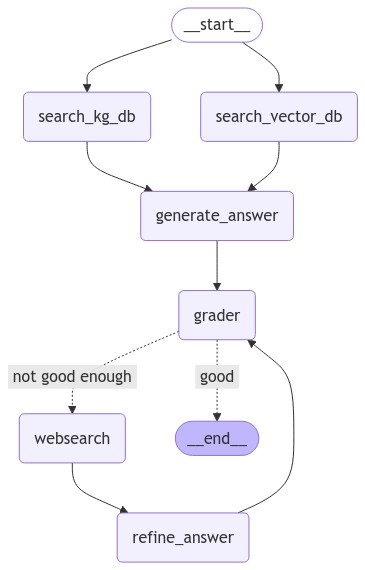

In [40]:
graph_png = graph.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    wrap_label_n_words=4,
    output_file_path=None,
    draw_method=MermaidDrawMethod.API,
    background_color="#000000",
    padding=10,
)

graph_base64 = base64.b64encode(graph_png).decode("utf-8")

HTML(f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{graph_base64}" width="400" height="auto"/>
</div>
''')

## Query The Workflow
1. Synchronous
2. Streamified

In [41]:
BASE_INPUTS = {
    "query": "",
    "agent": "",
    "kg_context": "",
    "db_context": "",
    "websearch_context": "",
    "metrics": defaultdict(str),
    "reasons": defaultdict(str),
    "answer": "",
}

In [42]:
user_queries = ["what are the potential long-term neurological and cardiovascular effects of chronic sleep deprivation in shift workers, particularly those in healthcare professions."]

inputs = BASE_INPUTS.copy()

for query in user_queries:
    inputs["query"] = query

    results = await graph.ainvoke(inputs)
    
    final_answer = results.get("answer", "")

INFO - ------- Retrieving Context Via KG DB -------
INFO - ------- Retrieving Context Via Vector DB -------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO - ------- Generating Answer -------
INFO - Generated Answer: The provided context does not contain information specifically addressing the long-term neurological and cardiovascular effects of chronic sleep deprivation in shift workers or healthcare professionals. The context primarily focuses on diabetes management, pre-diabetes, and insulin therapy. It does not discuss sleep deprivation or its effects on shift workers or healthcare professionals.
INFO - ------- Grading Answer -------
INFO - Grading Result: {'evaluation': {'relevance': 2, 'completeness': 1,

[LOG] 🌤️  Warming up the AsyncWebCrawler
[LOG] 🌞 AsyncWebCrawler is ready to crawl
[LOG] 🚀 Content extracted for https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3971766/, success: True, time taken: 0.13 seconds
[LOG] 🚀 Extraction done for https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3971766/, time taken: 0.13 seconds.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LOG] 🌤️  Warming up the AsyncWebCrawler
[LOG] 🌞 AsyncWebCrawler is ready to crawl
[LOG] 🚀 Content extracted for https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4629843/, success: True, time taken: 0.09 seconds
[LOG] 🚀 Extraction done for https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4629843/, time taken: 0.09 seconds.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO - ------- Refining Answer with KG Context -------


[LOG] 🌤️  Warming up the AsyncWebCrawler
[LOG] 🌞 AsyncWebCrawler is ready to crawl
[LOG] 🚀 Content extracted for https://www.sciencedirect.com/science/article/abs/pii/B9780444626271000238, success: True, time taken: 0.00 seconds
[LOG] 🚀 Extraction done for https://www.sciencedirect.com/science/article/abs/pii/B9780444626271000238, time taken: 0.00 seconds.


INFO - ------- Grading Answer -------
INFO - Grading Result: {'evaluation': {'relevance': 10, 'completeness': 9, 'coherence': 10, 'correctness': 9}, 'reasoning': {'relevance': 'The answer is highly relevant to the query, directly addressing both the neurological and cardiovascular effects of chronic sleep deprivation in shift workers, with a specific focus on healthcare professionals. It engages fully with all aspects of the question, providing a comprehensive overview of the potential long-term effects.', 'completeness': "The response is very comprehensive, covering a wide range of neurological and cardiovascular effects. It also includes additional health risks and mentions the specific statistic about healthcare workers not getting enough sleep. However, it could have provided more detailed information on some of the long-term neurological effects, such as potential impacts on memory or cognitive decline, which is why it doesn't receive a perfect score.", 'coherence': 'The answer is

In [43]:
print(final_answer)

Chronic sleep deprivation in shift workers, particularly those in healthcare professions, can have significant long-term neurological and cardiovascular effects. Based on the available context, here's an overview of the potential impacts:

Neurological effects:
1. Reduced cognitive performance: Shift work and long work hours increase the risk of fatigue-related errors and reduced performance on the job.
2. Sleep disturbances: Shift workers often experience short sleep duration and sleep disturbances, which can lead to chronic sleep deprivation.
3. Increased risk of injuries: Fatigue from shift work and long hours can increase the likelihood of workplace accidents and injuries.

Cardiovascular effects:
1. Increased risk of cardiovascular diseases: Shift work is associated with a higher risk of developing a wide range of chronic diseases, including cardiovascular conditions.
2. Obesity: Shift workers are at an increased risk of obesity, which is a known risk factor for cardiovascular dis